In [274]:
from jupyter_client import find_connection_file

connection_file = find_connection_file()
print(connection_file)

/home/yonatan/.local/share/jupyter/runtime/kernel-v2-168733O1aCw5OLLlK.json


In [275]:
# Plotting related
import os
import sys

sys.tracebacklimit = 0

import seaborn as sns

# sns.set_palette(["#3498db", "orange"])

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio


# Scikit-learn related imports
import numpy as np
import pandas as pd

pd.set_option("display.float_format", "{:.2f}".format)
pd.set_option("display.max_colwidth", None)
pd.options.mode.copy_on_write = True

from sklearn.model_selection import train_test_split, cross_validate, RandomizedSearchCV
from sklearn.metrics import accuracy_score
from scipy.stats import randint, ttest_ind
from sklearn.linear_model import LogisticRegression

# Jupyter-related
from IPython.display import Markdown as md


# Constants for this project
from constants import *

In [276]:
# Change the current working directory
os.chdir("/home/yonatan/Documents/projects/vaccines/code")

# maybe make plotly work
pio.renderers.default = "notebook"

In [277]:
def get_data_dir():
    # Define the starting directory
    current_dir = os.getcwd()

    # Traverse up the directory tree until we find a directory named "data"
    while current_dir != "/":
        if "data" in os.listdir(current_dir):
            data_dir = os.path.join(current_dir, "data")
            return data_dir
        current_dir = os.path.dirname(current_dir)
    else:
        print("Directory 'data' not found in the parent directories.")
        raise ()

In [278]:
# Read in Data and drop missing values
data_dir = get_data_dir()
df = pd.read_csv(os.path.join(data_dir, "../data/all_vaccines.csv"))
df.dropna(inplace=True, subset=[immage_col, dataset_col, day_col, response_col])

datasets = df
dataset_names = df.Dataset.unique()

In [279]:
# #### Distribution of studies' N values
N_vals = df[[dataset_col, uid_col]].groupby(dataset_col, as_index=False)[uid_col].nunique()
N_vals = N_vals.rename(columns={uid_col: "N"})
# sns.histplot(N_vals.N)
# plt.title("N values across studies")
# plt.show()

In [280]:
# Narrow N_v to large datasets only
bNarrow = False
large_N = N_vals.loc[N_vals["N"] > 70]
if bNarrow:
    print("Narrowing to large datasets only")
    datasets = df.loc[df["Dataset"].isin(large_N["Dataset"])]

dataset_names = datasets["Dataset"].unique()

In [281]:
# These parameters are overridden by papermill
strain_index = 0
dataset_name = "GSE59743.SDY400"
day = "FC.HAI"
day0 = "HAI.D0"
dayMFC = "HAI.MFC"

bAdjustMFC = False
bInfluenza = True
bDiscardSeroprotected = False
bOlderOnly = False

In [ ]:
# Parameters
bAdjustMFC = False
bDiscardSeroprotected = True
bInfluenza = True
bOlderOnly = False
dataset_name = "GSE48018.SDY1276"
strain_index = 0
day = "HAI.FC"


In [282]:
if bInfluenza:
    print("Working with Influenza datasets only")
    tmp_df = pd.DataFrame(influenza_dicts)
    datasets = df.loc[df["Dataset"].isin(tmp_df["Dataset"])]
    dataset_names = datasets["Dataset"].unique()
    tmp_df['Days'] = tmp_df['Days'].apply(lambda x: ', '.join(x) if isinstance(x, list) else x)  # Convert list to string for display
    # print(tmp_df)

Working with Influenza datasets only


In [283]:
# Narrow a specific datset
name_mask = datasets[dataset_col] == dataset_name
dataset = datasets.loc[name_mask].reset_index(drop=True)

In [284]:
# Calculate MFC for datasets which don't have it.
# Need to normalize day0 and then.. Look at the paper
# day_mask = dataset[day_col] == day
# t = dataset.loc[day_mask]
# t = dataset.groupby(uid_col)[response_col].max().reset_index()

In [285]:
# Pivot the dataset such that different days' samples appear in their own columns, witn NaN where there are missing samples
t = dataset[[dataset_col, uid_col, age_col, immage_col, "geo_accession", day_col, response_col]]
pivot_t = t.pivot_table(index=uid_col, columns=day_col, values=response_col, aggfunc='first')
age_t = dataset[['uid', 'Age']].drop_duplicates()

# Average IMMAGE values across geo_accessions (if they exist) and merge
immage_t = t.groupby('uid')[immage_col].mean()
tmp_t = age_t.merge(immage_t, on='uid', how='left').drop_duplicates()
pivot_t = tmp_t.merge(pivot_t, on='uid', how='left')

# Reset index to make uid a column again
pivot_t.reset_index(inplace=True, drop=True)

# Remove the name of the columns and index name
pivot_t.columns.name = None
pivot_t.index.name = None

# TODO complete generating MFC for this dataset
# if dataset_name == 'SDY296' or dataset_name == 'GSE48023.SDY1276':
#     dataset = dataset.loc[(~pivot_t[day0].isna()) & (~pivot_t["FC.HAI"].isna())]
#     pivot_t[dayMFC] = pivot_t[day] / pivot_t[day0]

# Currently only used by AdjustMFC branch. TODO: convert the "regular" to use it too
pivot_dataset = pivot_t

In [286]:
# Sometimes there are multiple geo_accession numbers, like in GSE48018.SDY1276.
# Average the IMMAGE, since all else is the same
def remove_duplicate_accessions(dataset, immage_col, uid_col):
    first_uid = dataset.iloc[0][uid_col]
    accessions = dataset[dataset[uid_col] == first_uid]["geo_accession"].unique()
    if len(accessions) > 1:
        # print(f"Multiple accession detected, Collapsing by averaging on IMMAGE value")
        dataset = dataset.groupby(uid_col, as_index=False).agg({immage_col: "mean", **{col: "first" for col in dataset.columns if col not in [uid_col, immage_col]},})

    accessions = dataset[dataset[uid_col] == first_uid]["geo_accession"].unique()
    assert len(accessions) == 1

    return dataset

In [287]:
from sklearn.cluster import KMeans
# Use adjusted MFC (HAI) as per John Tsang
cluster_col = day0
if bAdjustMFC:
    exit(1)
    dataset = pivot_dataset[[uid_col, immage_col, age_col, day0, dayMFC]]
    print("Preprocessing dataset, computing adjusted MFC (HAI)")
    dataset = dataset.loc[(~pivot_t[day0].isna()) & (~pivot_t[dayMFC].isna())]

    mean = dataset[day0].mean()
    std = dataset[day0].std()
    threshold = 3 * std
    dataset = dataset[(dataset[day0] >= mean - threshold) & (dataset[day0] <= mean + threshold)]

    # Bin subjects into 2-3 bins using k-means clustering
    kmeans = KMeans(n_clusters=3, random_state=0)
    dataset['Cluster'] = kmeans.fit_predict(dataset[[cluster_col]])

    def normalize(x):
        return (x - x.median()) / x.std()

    # Normalize the MFC within each bin to obtain the adjMFC
    dataset['adjMFC'] = dataset.groupby('Cluster')[dayMFC].transform(normalize)

    # Take relevant columns only
    data = dataset[[immage_col, 'adjMFC', age_col, cluster_col, "Cluster"]].rename(columns={'adjMFC': response_col}).dropna()
    # data.groupby("Cluster").count()
    strain = "Influenza"
    strains = "Influenza"

In [288]:
# Visualize clusters
if bAdjustMFC:
    custom_palette = {0: "red", 1: "blue", 2: "green"}
    sorted_data = data.sort_values(cluster_col, ignore_index=True).reset_index()
    sns.scatterplot(data=sorted_data, x="index", y=cluster_col, hue="Cluster", palette=custom_palette)
    # plt.axhline(y=threshold, color="black", linestyle="--")
    plt.title(f"{cluster_col} clustered")

In [289]:
# Discard seroprotected subjects based on HAI > 40 threshold)
if bDiscardSeroprotected:
    HAI_threshold = 40
    day0_mask = dataset[day_col] == day0
    threshold_mask = dataset[response_col ]> HAI_threshold

    # Get a list of all protected patients
    serprotected_subjects = dataset.loc[(day0_mask) & (threshold_mask)][uid_col].unique()
    # keep only patients not in the serprotected_subjects list
    dataset = dataset.loc[~dataset[uid_col].isin(serprotected_subjects)]
    subjects_left = dataset[uid_col].unique()
    print(f"Discarding {len(serprotected_subjects)} seroprotected subjects")
    print(f"Subjects left: N={len(subjects_left)}")

In [290]:
if bAdjustMFC == False:
    # If not computing adjMFC, take a specific strain from the given post-vaccine day & assay
    dayMFC_mask = dataset[day_col] == day
    dataset = dataset.loc[(dayMFC_mask)].reset_index(drop=True)

    # Somtimes there are multiple strains - so multiple rows per day
    strains = dataset[strain_col].unique()
    if len(strains) > 1:
        dataset = dataset.loc[dataset[strain_col] == strains[strain_index]].reset_index(drop=True)

    strains_t = dataset[strain_col].unique()
    assert len(strains_t) == 1
    strain = strains_t[0]

    dataset = remove_duplicate_accessions(dataset, immage_col, uid_col)

    # Take relevant columns only
    data = dataset[[immage_col, response_col, age_col]]

In [291]:
# Keep older subjects only, since that's what's actually more interesting, and may show IMMAGE's advantage
age_threshlod = 60
if bOlderOnly == True:
    data = data.loc[data[age_col] > age_threshlod]
    if len(data) == 0:
        raise(Exception("No subjects over the age of {age_threshlod}. Exiting."))

#### Dataset & Strain info

In [292]:
age_restrict_str = f", Subjects over the age of {age_threshlod}" if bOlderOnly else ""
day_str = "Adjusted MFC" if bAdjustMFC else f"day: {day}"

md(f"""## Analysis for dataset: {dataset_name}, strain: {strain}, {day_str}{age_restrict_str}""")

## Analysis for dataset: GSE59743.SDY400, strain: B/Wisonsin/01/2010, day: FC.HAI

In [293]:
md(
    f"""Working with dataset: {dataset_name}, strain: {strain}, {day_str}\n
Total subjects in study: N = {data.shape[0]}\n
Other strains in this study: {strains}"""
)

Working with dataset: GSE59743.SDY400, strain: B/Wisonsin/01/2010, day: FC.HAI

Total subjects in study: N = 28

Other strains in this study: ['B/Wisonsin/01/2010' 'A/Victoria/361/2011' 'A/California/7/2009']

In [294]:
data.reset_index(inplace=True, drop=True)

# Get a boolean map of sub and super threshold values
low_response_thr = data[[response_col]].quantile(q=0.3).item()

# Generate labels
# Note that we define y=1 for all responses <= 30th percentile (and not <)
# Also note that we defined y=1 as *non* responders, since later on that's what we'll care about detecting

data["y"] = data[response_col].apply(lambda x: 1 if x <= low_response_thr else 0)

# Add a text label for plot legends
data["Label text"] = data["y"].apply(lambda x: "Responders" if x == 0 else "Non-Responders")

#### Dynamic ranges of IMMAGE, response, and age values

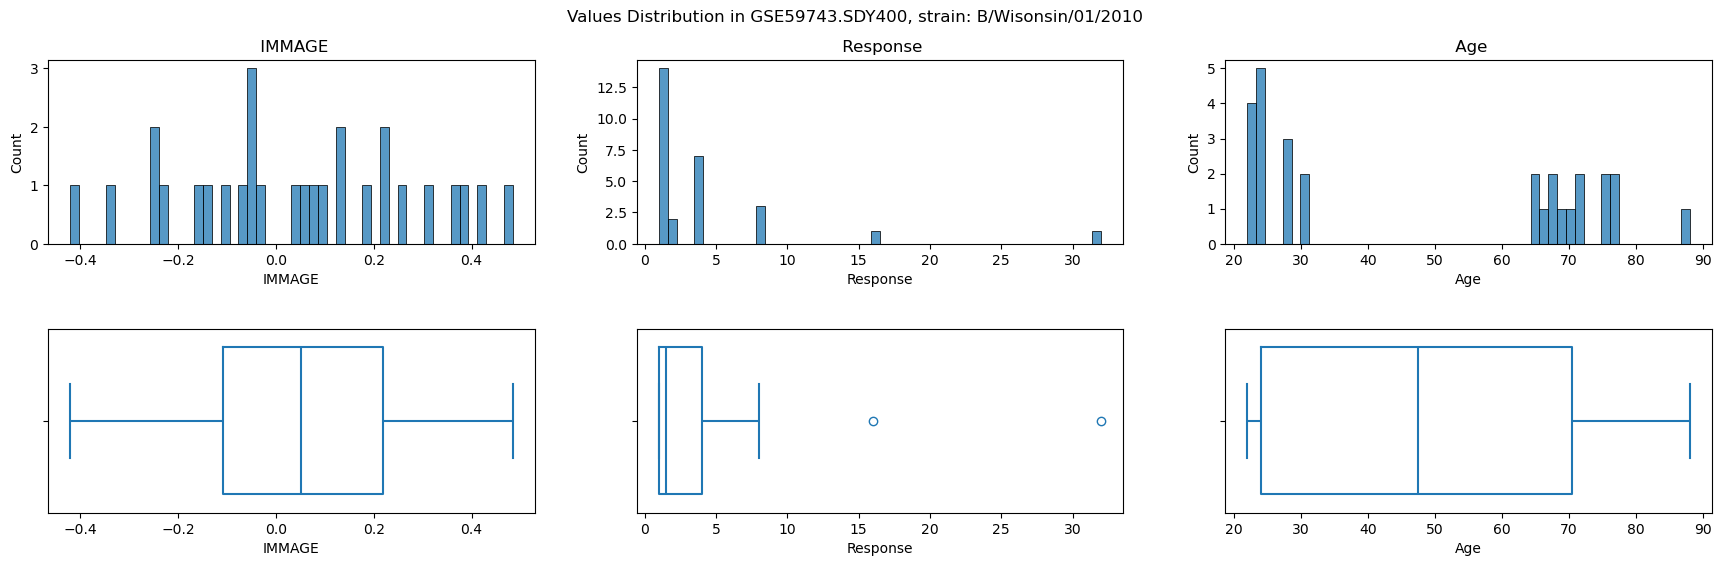

In [295]:
# Plot IMMAGE, response, and age values to look at the dynamic range
from scipy.stats import probplot

fig, axs = plt.subplots(2, 3, figsize=(18, 6))  # Create a figure with two subplots side by side

sns.histplot(data=data, x=immage_col, bins=50, ax=axs[0, 0])
sns.boxplot(data=data, x=immage_col, ax=axs[1, 0], fill=False)
# axs[0].set_title('Box Plot')
axs[0, 0].set_title(f" {immage_col}")

sns.histplot(data=data, x=response_col, bins=50, ax=axs[0, 1])
sns.boxplot(data=data, x=response_col, ax=axs[1, 1], fill=False)
# axs[1].set_title('Box Plot')
axs[0, 1].set_title(f" {response_col}")

sns.histplot(data=data, x=age_col, bins=50, ax=axs[0, 2])
sns.boxplot(data=data, x=age_col, ax=axs[1, 2], fill=False)
# axs[1].set_title('Box Plot')
axs[0, 2].set_title(f" {age_col}")

plt.tight_layout(pad=3.0)  # Adjust the layout so everything fits without overlap
fig.suptitle(f"Values Distribution in {dataset_name}, strain: {strain}")

plt.show()

In [296]:
# Classifying with logistic regression - fit on the entire dataset
from math import log


def get_threshold_from_probability(prob, intercept, slope):
    return -1 * (log(1 / prob - 1) + intercept) / slope


log_regress_immage = LogisticRegression()
log_regress_age = LogisticRegression()
log_regress_combined = LogisticRegression()

# Train a classifier based on immage and on age for comparison
log_regress_immage.fit(data[[immage_col]], data["y"])
log_regress_age.fit(data[[age_col]], data["y"])
log_regress_combined.fit(data[[immage_col, age_col]], data["y"])

non_responder_col = "p_non_responder"
non_responder_col_age = "p_non_responder_age"
non_responder_col_combined = "p_non_responder_combined"

# data.reset_index(in_place=True, drop=True)

proba = pd.DataFrame(log_regress_immage.predict_proba(data[[immage_col]]))
data[non_responder_col] = proba[1]
proba = pd.DataFrame(log_regress_age.predict_proba(data[[age_col]]))
data[non_responder_col_age] = proba[1]
proba = pd.DataFrame(log_regress_combined.predict_proba(data[[immage_col, age_col]]))
data[non_responder_col_combined] = proba[1]

In [297]:
# Define auxilary functions
from sklearn.metrics import auc, roc_auc_score, roc_curve
from math import log


def calc_and_plot_prob_threshold(data, classifier, fpr, tpr, thresholds, col_name=""):
    roc_auc = auc(fpr, tpr)
    intercept = classifier.intercept_[0]
    slope = classifier.coef_[0][0]

    # Identifying the optimal threshold (using Youden’s Index)
    optimal_idx = np.argmax(tpr - fpr)
    prob_threshold = thresholds[optimal_idx]

    # Calculate the cutoff value
    feature_threshold = get_threshold_from_probability(
        prob_threshold, intercept=intercept, slope=slope
    )

    fig, axs = plt.subplots(
        1, 2, figsize=(16, 6)
    )  # Creates a figure with two side-by-side subplots

    # Plot ROC curve on the first subplot
    axs[0].plot(fpr, tpr, label=f"ROC curve (area = {roc_auc : 0.2f})", color="#9b59b6")
    axs[0].plot([0, 1], [0, 1], "k--")  # Random chance line
    axs[0].plot(fpr[optimal_idx], tpr[optimal_idx], marker="o", markersize=5, color="red")
    axs[0].set_xlim([0.0, 1.0])
    axs[0].set_ylim([0.0, 1.05])
    axs[0].set_xlabel("False Positive Rate")
    axs[0].set_ylabel("True Positive Rate")
    axs[0].set_title("ROC curve")
    axs[0].legend(loc="lower right")

    # Plot sorted feature values vs Index on the second subplot
    custom_palette = {"Non-Responders": "orange", "Responders": "#3498db"}
    sorted_data = data.sort_values(col_name, ignore_index=True).reset_index()
    sns.scatterplot(
        ax=axs[1], data=sorted_data, x="index", y=col_name, hue="Label text", palette=custom_palette
    )
    axs[1].axhline(y=feature_threshold, color="black", linestyle="--")
    axs[1].set_title(f"Sorted {col_name} vs Index")

    fig.suptitle(f"Probability-based threshold with ROC\n({dataset_name}, {strain})")
    plt.tight_layout()  # Adjusts subplot params so that subplots fit into the figure area.
    plt.show()

    return (prob_threshold, feature_threshold, roc_auc)


def calc_and_plot_prob_threshold_multivar(data, classifier, fpr, tpr, thresholds, features=""):
    roc_auc = auc(fpr, tpr)
    intercept = classifier.intercept_[0]
    slope = classifier.coef_[0][0]

    # Identifying the optimal threshold (using Youden’s Index)
    optimal_idx = np.argmax(tpr - fpr)
    prob_threshold = thresholds[optimal_idx]

    # Calculate the cutoff value
    feature_threshold = get_threshold_from_probability(
        prob_threshold, intercept=intercept, slope=slope
    )

    fig, axs = plt.subplots(1, 2, figsize=(16, 6))

    # Plot ROC curve on the first subplot
    axs[0].plot(fpr, tpr, color="#9b59b6", label=f"ROC curve (area = {roc_auc : 0.2f})")
    axs[0].plot([0, 1], [0, 1], "k--")  # Random chance line
    axs[0].plot(fpr[optimal_idx], tpr[optimal_idx], marker="o", markersize=5, color="red")
    axs[0].set_xlim([0.0, 1.0])
    axs[0].set_ylim([0.0, 1.05])
    axs[0].set_xlabel("False Positive Rate")
    axs[0].set_ylabel("True Positive Rate")
    axs[0].set_title("ROC curve")
    axs[0].legend(loc="lower right")

    # Plot sorted IMMAGE values vs Index on the second subplot
    # Define a custom color palette
    custom_palette = {"Non-Responders": "orange", "Responders": "#3498db"}
    sns.scatterplot(
        ax=axs[1], data=data, x=features[0], y=features[1], hue="Label text", palette=custom_palette
    )
    # axs[1].axhline(y=feature_threshold, color="black", linestyle="--")
    axs[1].set_title(f"IMMAGE and Age labels")

    fig.suptitle(f"Probability-based threshold with ROC\n({dataset_name}, {strain})")
    plt.tight_layout()  # Adjusts subplot params so that subplots fit into the figure area.
    plt.show()

    return (
        prob_threshold,
        feature_threshold,
        roc_auc,
    )  # feature threshold is meaningless for the multivariate case


def get_classifier_stats_prob(data, prob_column, prob_threshold):
    # Global measures (entire dataset)
    optimal_pred = data[prob_column].apply(lambda x: 1 if x >= prob_threshold else 0)
    test_accuracy = accuracy_score(data["y"], optimal_pred)
    # Performance above the prob_threshold
    y_over_thr = data.loc[data[prob_column] >= prob_threshold, ["y"]]
    non_response_rate_over_thr = y_over_thr.mean().y
    y_under_thr = data.loc[data[prob_column] < prob_threshold, ["y"]]
    non_response_rate_under_thr = y_under_thr.mean().y
    return non_response_rate_over_thr, non_response_rate_under_thr

#### Thresholding based on logistic regression probabilties

#### IMMAGE-based classification

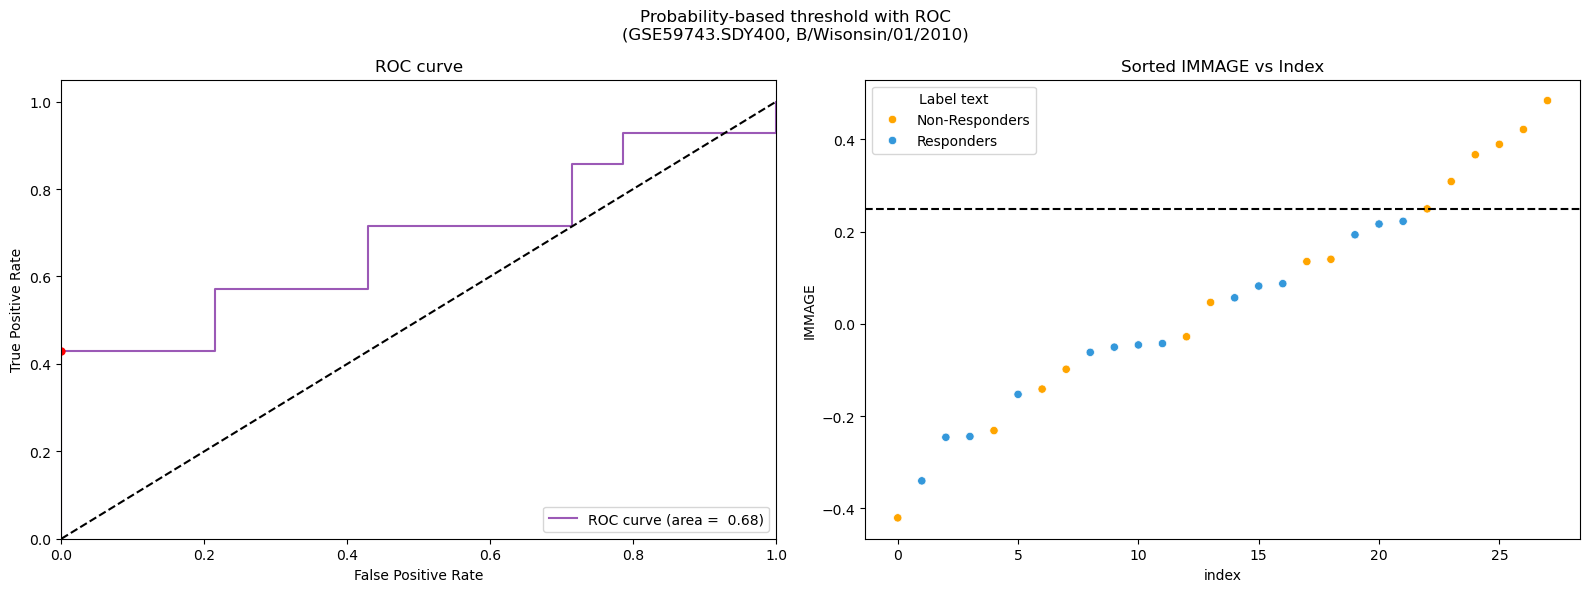

In [298]:
# Run for immage and age to compare
# IMMAGE
fpr, tpr, thresholds = roc_curve(data["y"], data[non_responder_col])
prob_threshold, immage_threshold, immage_roc_auc = calc_and_plot_prob_threshold(
    data, log_regress_immage, fpr, tpr, thresholds, col_name=immage_col
)
non_response_rate_over_thr, non_response_rate_under_thr = get_classifier_stats_prob(
    data, non_responder_col, prob_threshold
)

#### Age-based classification

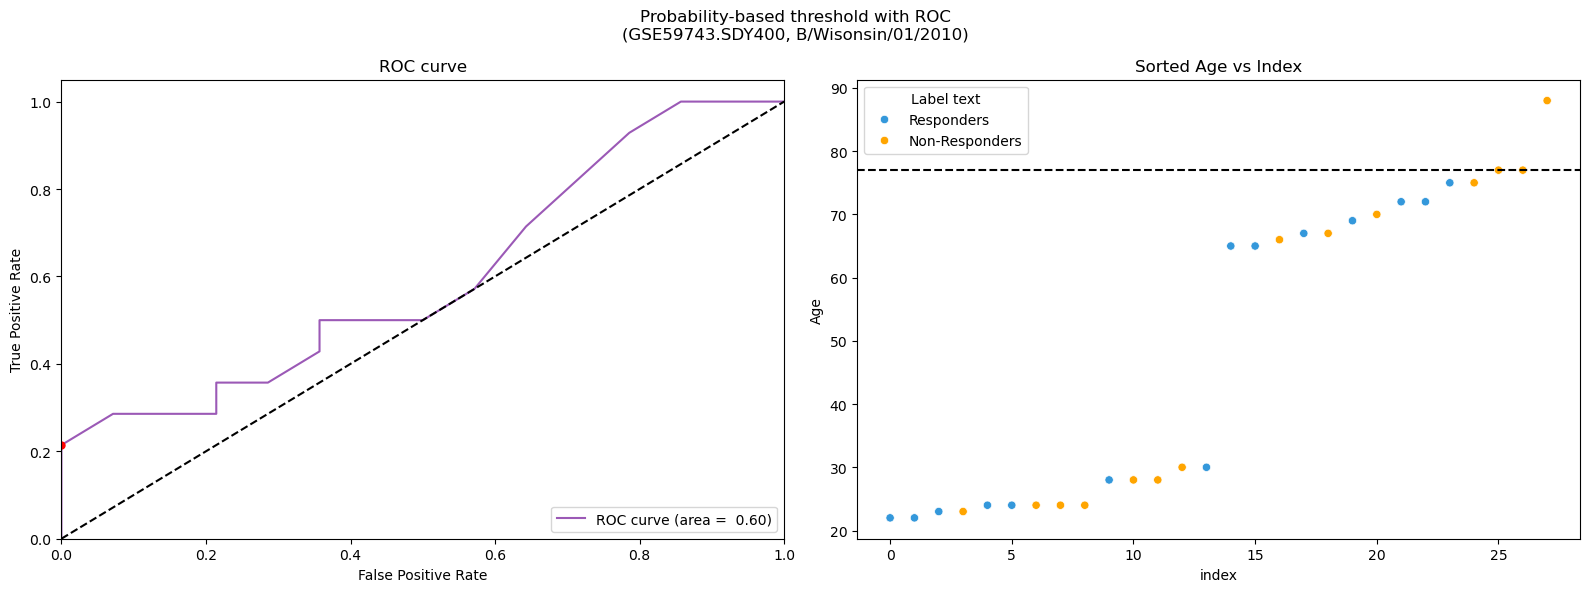

In [299]:
# Age
fpr, tpr, thresholds = roc_curve(data["y"], data[non_responder_col_age])
prob_threshold_age, age_threshold, age_roc_auc = calc_and_plot_prob_threshold(
    data, log_regress_age, fpr, tpr, thresholds, col_name=age_col
)
age_non_response_rate_over_thr, age_non_response_rate_under_thr = get_classifier_stats_prob(
    data, non_responder_col_age, prob_threshold_age
)

#### Age & IMMAGE combined

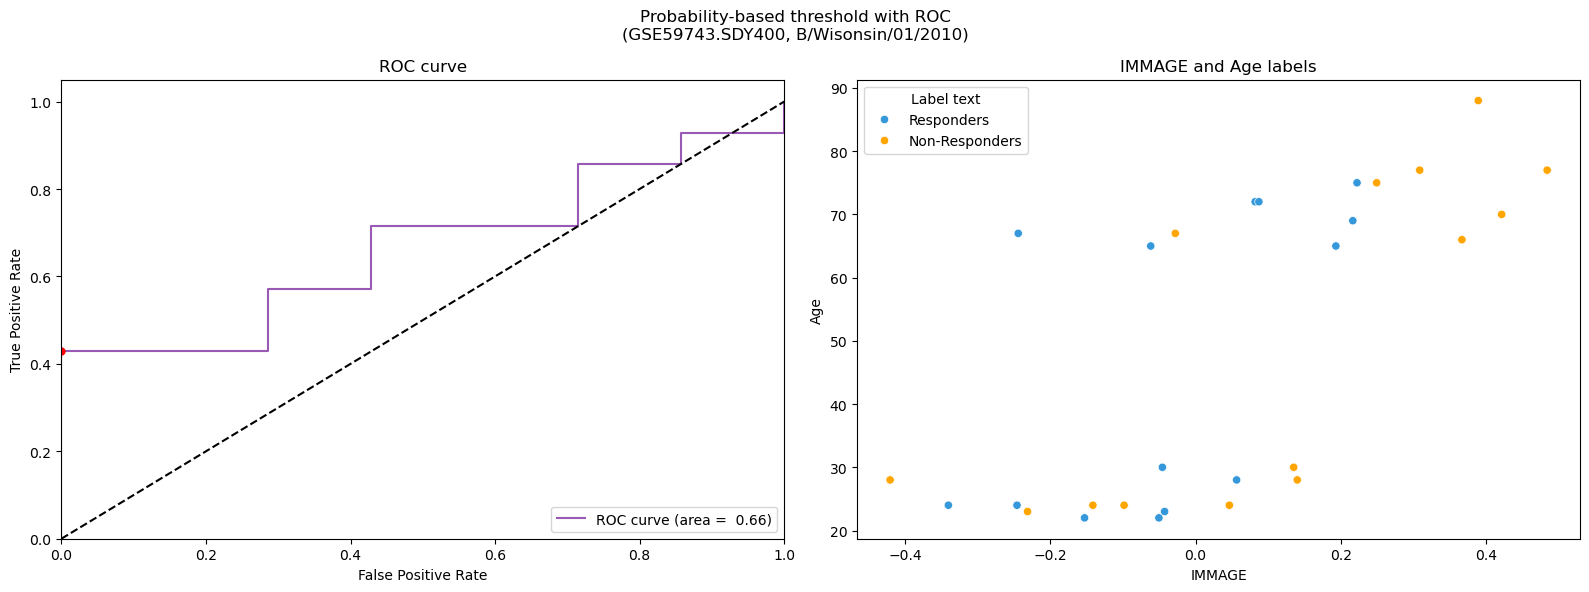

In [300]:
# Combined
fpr, tpr, thresholds = roc_curve(data["y"], data[non_responder_col_combined])
prob_threshold_combined, _, combined_roc_auc = calc_and_plot_prob_threshold_multivar(
    data, log_regress_combined, fpr, tpr, thresholds, features=[immage_col, age_col]
)
combined_non_response_rate_over_thr, combined_non_response_rate_under_thr = (
    get_classifier_stats_prob(data, non_responder_col_combined, prob_threshold_combined)
)

#### Comparison of using the different features

In [301]:
%%script true
print(
    f'''IMMAGE:
    Optimal threshold: {immage_threshold : 0.2f} (IMMAGE value)
    Non-responder rate:
      over threshold: {non_response_rate_over_thr : 0.2f}
      under threshold: {non_response_rate_under_thr : 0.2f}\n'''
);
print(
    f'''Age:
    Optimal threshold: {age_threshold : 0.2f} (Age)
    Non-responder rate:
      over threshold: {age_non_response_rate_over_thr : 0.2f}
      under threshold: {age_non_response_rate_under_thr : 0.2f}\n'''
);
print(
    f'''Multivariate:
    Optimal threshold: {prob_threshold_combined : 0.2f} (probability)
    Non-responder rate:
    over threshold: {combined_non_response_rate_over_thr : 0.2f}
    under threshold: {combined_non_response_rate_under_thr : 0.2f}\n'''
);

In [302]:
summary = {
    "Variable": ["IMMAGE", "Age", "Multivariate"],
    "Optimal threshold": [immage_threshold, age_threshold, prob_threshold_combined],
    "ROC AUC": [immage_roc_auc, age_roc_auc, combined_roc_auc],
    "Non response over threshold": [
        non_response_rate_over_thr,
        age_non_response_rate_over_thr,
        combined_non_response_rate_over_thr,
    ],
    "Non response under threshold": [
        non_response_rate_under_thr,
        age_non_response_rate_under_thr,
        combined_non_response_rate_under_thr,
    ],
}

df = pd.DataFrame(summary)
print(df.to_string(index=False))

    Variable  Optimal threshold  ROC AUC  Non response over threshold  Non response under threshold
      IMMAGE               0.25     0.68                         1.00                          0.36
         Age              77.00     0.60                         1.00                          0.44
Multivariate               0.54     0.66                         1.00                          0.36


#### Sliding window analysis

In [303]:
# Sliding window instead of bins, plotting non-reponder rate vs window start
def generate_windows(data, feature_col, num_units, num_units_per_window):
    """
    Generates window start and end points based on the specified feature column in the data.
    """
    window_starts = np.linspace(
        start=data[feature_col].min(), stop=data[feature_col].max(), num=num_units
    )
    window_size = (
        (data[feature_col].max() - data[feature_col].min()) / num_units * num_units_per_window
    )
    window_starts = pd.Series(window_starts)
    windows = pd.DataFrame({"start": window_starts[:-num_units_per_window].reset_index(drop=True), "end": window_starts[num_units_per_window:].reset_index(drop=True)})
    return windows, window_size


def calculate_rates(data, windows, feature_col):
    """
    Calculates the rate for each window based on the occurrences within that window: non-reponders/all-subjects-in-window.
    """
    rates = []

    for i, start, end in windows.itertuples():
        over = data[feature_col] >= windows["start"][i]
        under = data[feature_col] < windows["end"][i]
        rates.append(data.loc[(over & under), "y"].mean())

    rates = pd.Series(rates).fillna(0)
    windows["rate"] = rates

    return windows


def calculate_rates_total(data, windows, feature_col):
    """
        Calculates the rate for each window based on the relation of each window to total population: window-non-reponders/all-non-responders.
    _"""
    rates = []
    total_non_responders = data["y"].sum()

    for i, start, end in windows.itertuples():
        over = data[feature_col] >= windows["start"][i]
        under = data[feature_col] < windows["end"][i]
        rates.append(data.loc[(over & under), "y"].sum() / total_non_responders)

    rates = pd.Series(rates).fillna(0)
    windows["rate"] = rates

    return windows


def generate_windows_and_rates(data, feature_col, num_units, num_units_per_window, total=False):
    windows, window_size = generate_windows(data, feature_col, num_units, num_units_per_window)
    if total:
        windows = calculate_rates_total(data, windows, feature_col)
    else:
        windows = calculate_rates(data, windows, feature_col)

    return windows, window_size

##### "Local" metric

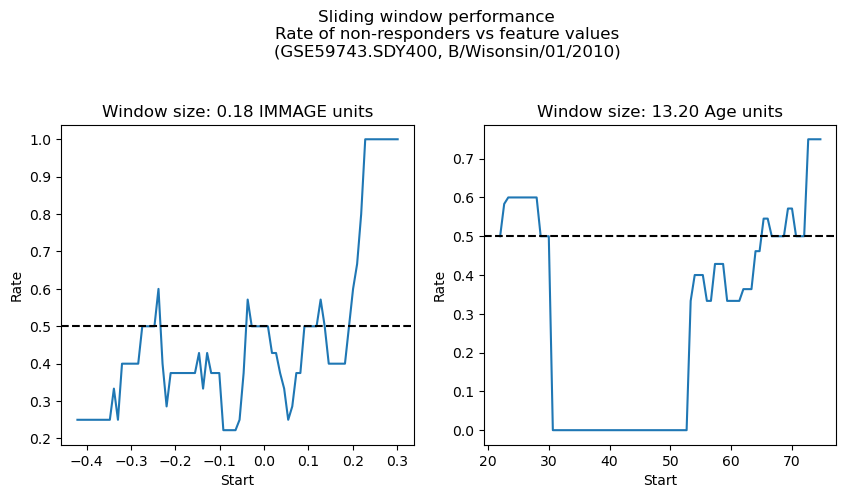

In [304]:
num_units = 100
feature_cols = [immage_col, age_col]
num_features = len(feature_cols)

# Plot windows with "local" rate
fig, axs = plt.subplots(1, num_features, figsize=(5 * num_features, 5))

for i, feature_col in enumerate(feature_cols):
    windows, window_size = generate_windows_and_rates(data, feature_col, num_units, 20, total=False)
    sns.lineplot(data=windows, x="start", y="rate", ax=axs[i])
    axs[i].axhline(y=0.5, color="black", linestyle="--")
    axs[i].set_title(f"Window size: {window_size:.2f} {feature_col} units")
    axs[i].set_xlabel("Start")
    axs[i].set_ylabel("Rate")

fig.suptitle(
    f"""Sliding window performance
    Rate of non-responders vs feature values
    ({dataset_name}, {strain})"""
)
plt.subplots_adjust(top=0.75)

plt.show()

##### "Global" metric

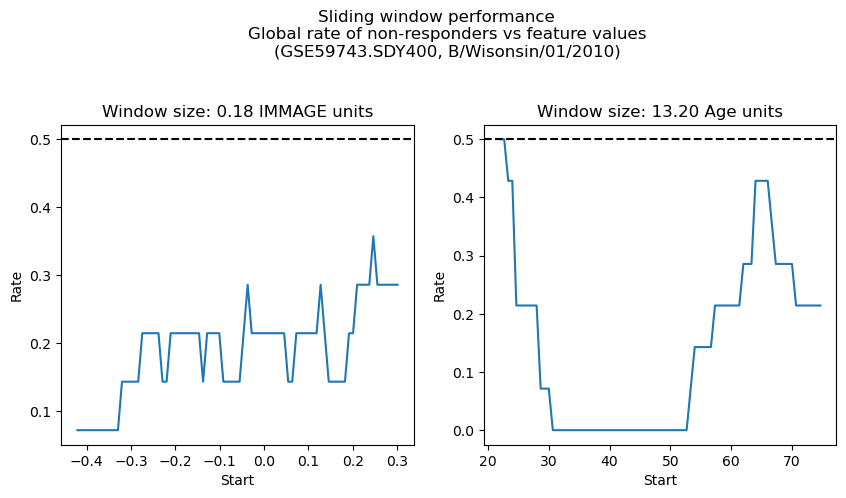

In [305]:

# Plot windows with "global" rate
fig, axs = plt.subplots(1, num_features, figsize=(5 * num_features, 5))

for i, feature_col in enumerate(feature_cols):
    windows, window_size = generate_windows_and_rates(data, feature_col, num_units, 20, total=True)
    sns.lineplot(data=windows, x="start", y="rate", ax=axs[i])
    axs[i].axhline(y=0.5, color="black", linestyle="--")
    axs[i].set_title(f"Window size: {window_size:.2f} {feature_col} units")
    axs[i].set_xlabel("Start")
    axs[i].set_ylabel("Rate")

fig.suptitle(
    f"""Sliding window performance
    Global rate of non-responders vs feature values
    ({dataset_name}, {strain})"""
)
plt.subplots_adjust(top=0.75)

plt.show()

In [306]:
# 2D sliding windows - not worth the time it take to make this work
feature1 = immage_col
feature2 = age_col
f1_windows, size1 = generate_windows(data, feature1, 100, 20)
f2_windows, size2 = generate_windows(data, feature2, 100, 20)
windows = pd.concat([f1_windows, f2_windows], keys=["f1_windows", "f2_windows"], axis=1)
rates = []
for i, start1, end1, start2, end2 in windows.itertuples():
    over1 = data[feature1] >= start1
    under1 = data[feature1] < end1
    over2 = data[feature2] >= start2
    under2 = data[feature2] < end2
    # mean is summing the positive labels = # of positives and dividing by the total # of subjects in that group
    rates.append(data.loc[(over1 & under1 & over2 & under2), "y"].mean())

rates = pd.Series(rates).fillna(0)
windows["rate"] = rates
# rate_matrix = data.groupby(['f1_bin', 'f2_bin'])[target].mean().unstack().fillna(0)


def calculate_2d_rates(data, feature1, feature2, target, num_bins=10):
    f1_windows = generate_windows(data, feature1, 100, 20)
    f2_windows = generate_windows(data, feature2, 100, 20)
    windows = pd.DataFrame({"f1_windows": f1_windows, "f2_windows": f2_windows})

    for i, start1, end1, start2, end2 in windows.itertuples():
        over1 = data[feature1] >= start1
        under1 = data[feature1] < end1
        over2 = data[feature2] >= start2
        under2 = data[feature2] < end2
        # mean is summing the positive labels = # of positives and dividing by the total # of subjects in that group
        rates.append(data.loc[(over1 & under1 & over2 & under2), "y"].mean())

    rates = pd.Series(rates).fillna(0)
    windows["rate"] = rates
    rate_matrix = data.groupby(["f1_bin", "f2_bin"])

    return rate_matrix


def plot_2d_rates(rate_matrix):
    # Plot as a heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(rate_matrix, annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Rate of Non-Responders by 2D Feature Bins")
    plt.xlabel("Feature 2 Bin")
    plt.ylabel("Feature 1 Bin")
    plt.show()


# Calculate and plot
# rate_matrix = calculate_2d_rates(data, 'feature1', 'feature2', 'y', num_bins=5)
# plot_2d_rates(rate_matrix)